# Model Comparison using SciKit-learn K-Fold Cross Validation

In this example, I will train the [Vertebral Column Dataset](https://www.kaggle.com/datasets/jessanrod3/vertebralcolumndataset) and compare accuracies using 6 methods: logistic regression, k-nearest neighbors, support-vector machine, naive bayes, decission tree and random forest. 

## 1. Data description

In [3]:
# Import needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') # hides warnings to get proper outputs

In [4]:
# read dataset and show 5 first lines
dataset = pd.read_csv('data/data.csv')
dataset.head()

,pelvic incidence,pelvic tilt,lumbar lordosis angle,sacral slope,pelvic radius,grade of spondylolisthesis,Class_att
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Abnormal


In [5]:
# Show statistics of the dataset
dataset.describe()

,pelvic incidence,pelvic tilt,lumbar lordosis angle,sacral slope,pelvic radius,grade of spondylolisthesis
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496653,17.542822,51.930930,42.953831,117.920655,25.027289
std,17.236520,10.008330,18.554064,13.423102,13.317377,30.185249
min,26.147921,-6.554948,14.000000,13.366931,70.082575,-11.058179
25%,46.430294,10.667069,37.000000,33.347122,110.709196,1.603727
50%,58.691038,16.357689,49.562398,42.404912,118.268178,11.767934
75%,72.877696,22.120395,63.000000,52.695888,125.467674,40.788437
max,129.834041,49.431864,125.742385,121.429566,163.071041,148.753711


## 2. Variables traitment

The dataset is composed by 6 numerical variables and a categorical classification class. This last one will be numerically transformed so Abnormal classification will have the number 1 and Normal the number 0. After that, dataset will be divided into x, with first 6 variables, and y, with the classification variable.

There are no NaN neither outliers because they have been treated previously in [VertebralColumnVariablesAnalyse](https://jsr90.github.io/VertebralColumnVariablesAnalyse/).

In [6]:
Class_att = {'Abnormal': 1,'Normal': 0}

dataset.Class_att = [Class_att[item] for item in dataset.Class_att]
dataset.Class_att.value_counts()

1    210
0    100
Name: Class_att, dtype: int64

In [7]:
y = dataset.Class_att
x = dataset.drop(['Class_att'], axis=1)

## 3. Fitting model using pipeline

### 3.1 Defining models and scores

In [8]:
# Import needed libraries for each model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Define models
lr = LogisticRegression(max_iter=10000, tol=0.1)
knn = KNeighborsClassifier(n_neighbors=4)
svm=SVC(random_state=42)
nb=GaussianNB()
dt=DecisionTreeClassifier(random_state=42)
rf=RandomForestClassifier(n_estimators=100, random_state=42)

In [9]:

from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score

# Define scoring
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score)}

### 3.2 Defining K-fold as Cross Validation method

In [10]:
from sklearn.model_selection import KFold

# Set iterator to 10 splits
kfold = KFold(n_splits=10)

# Set methods objects and names
class_method=[lr,knn,svm,nb,dt,rf]
comparison_matrix=pd.DataFrame()
method_name=["lr","knn","svm","nb","dt","rf"]

### 3.3 Setting Pipeline

Pipeline allows to preprocess data so in each iteration, standarisation is applied in both test and train datasets, using train mean and sd.

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.model_selection import cross_validate

# Set an empty matrix to store every result
comparison_matrix = pd.DataFrame()

# Loop for each model
for each in class_method:

    # Set the clasifier with standarisation for each model
    clf=make_pipeline(preprocessing.StandardScaler(), each)
    
    # Get results for each iteration
    results = cross_validate(estimator=clf,
                                              X=x,
                                              y=y,
                                              cv=kfold,
                                              scoring=scoring)
    
    results = pd.DataFrame(results)

    # Keep the mean of 10 iterations and append it to the data frame
    results = results.mean()
    comparison_matrix = pd.concat([comparison_matrix, results], axis=1)

# Set columns names and print matrix    
comparison_matrix.columns = method_name
print(comparison_matrix)

                      lr       knn       svm        nb        dt        rf
fit_time        0.002384  0.001556  0.002191  0.001414  0.001835  0.060354
score_time      0.001398  0.002134  0.001495  0.001303  0.001328  0.005832
test_accuracy   0.774194  0.719355  0.783871  0.764516  0.758065  0.767742
test_precision  0.696000  0.695833  0.692308  0.700000  0.696000  0.692308
test_recall     0.580645  0.499059  0.577419  0.519355  0.564516  0.583871


### 3.4 Plotting results

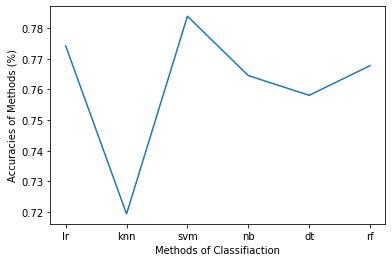

In [12]:
# Store method accuracies and plot them with their method name

method_acc = []
for i in comparison_matrix.iloc[2:3,:].values:
    method_acc.append(i)

plt.plot(method_name, method_acc[0])
plt.xlabel("Methods of Classifiaction")
plt.ylabel("Accuracies of Methods (%)")
plt.show()

### 3.5 Making the model persistent

Since SVM got the highest accuracy, the next step allows us to store the model in our machine so it'll be available. We can do it using joblib library.

In [13]:
from joblib import dump
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([('scaler', StandardScaler()), ('svm', svm)])
pipe.fit(x, y)

dump(pipe, 'models/model.joblib') 

['models/model.joblib']